In [2]:
import numpy as np
import matplotlib.pyplot as plt
from utilities import *
from sklearn.datasets import make_blobs, make_circles, make_moons
from sklearn.metrics import accuracy_score, log_loss
from tqdm import tqdm

Dataset

In [3]:
# data load and initilisiation
X_train, y_train, X_test, y_test = load_data()
X_train_reshape = X_train.reshape(X_train.shape[0], -1) / X_train.max()
X_test_reshape = X_test.reshape(X_test.shape[0], -1) / X_train.max()

# data transposition
X_train_reshape = X_train_reshape.T
y_train = y_train.T
X_test_reshape = X_test_reshape.T
y_test = y_test.T

# dynamic adjustment of m_train and m_test
m_train = min(300, X_train_reshape.shape[1])
m_test = min(80, X_test_reshape.shape[1])

# data cut with ajusted sizes
X_train_reshape = X_train_reshape[:, :m_train]
y_train = y_train[:, :m_train]
X_test_reshape = X_test_reshape[:, :m_test]
y_test = y_test[:, :m_test]

# data check
print(f"Dimensions X_train: {X_train_reshape.shape}, y_train: {y_train.shape}")
print(f"Dimensions X_test: {X_test_reshape.shape}, y_test: {y_test.shape}")

# size check
def validate_output_dimensions(Af, y_test):
    if Af.shape[1] != y_test.shape[1]:
        raise ValueError(f"Mismatch in dimensions: Af has {Af.shape[1]} samples, y_test has {y_test.shape[1]} samples")
    print(f"Output dimensions are consistent: Af: {Af.shape}, y_test: {y_test.shape}")

Dimensions X_train: (4096, 300), y_train: (1, 300)
Dimensions X_test: (4096, 80), y_test: (1, 80)


Functions

In [4]:
def initialisation(dimensions):
    parametres = {}
    C = len(dimensions)

    for c in range(1, C):
        parametres['W' + str(c)] = np.random.randn(dimensions[c], dimensions[c-1])
        parametres['b' + str(c)] = np.random.randn(dimensions[c], 1)

    return parametres

In [5]:
def forward_propagation(X, parametres):
    activations = {'A0' : X}
    C = len(parametres) // 2

    for c in range(1, C+1):
        Z = parametres['W' + str(c)].dot(activations['A' + str(c-1)]) + parametres['b' + str(c)]
        activations['A' + str(c)] = 1 / (1 + np.exp(-Z))
    
    return activations

In [6]:
def back_propagation(y, parametres, activations):
    gradients = {}
    m = y.shape[1]
    C = len(parametres) // 2
    dZ = activations['A' + str(C)] - y

    for c in reversed(range(1, C+1)):
        gradients['dW' + str(c)] = 1/m * np.dot(dZ, activations['A' + str(c-1)].T)
        gradients['db' + str(c)] = 1/m * np.sum(dZ, axis=1, keepdims=True)
        if c > 1:
            dZ = np.dot(parametres['W' + str(c)].T, dZ) * activations['A' + str(c-1)] * (1 - activations['A' + str(c-1)])
    
    return gradients

In [7]:
def update(gradients, parametres, learning_rate):

    C = len(parametres) // 2

    for c in range(1, C + 1):
        parametres['W' + str(c)] = parametres['W' + str(c)] - learning_rate * gradients['dW' + str(c)]
        parametres['b' + str(c)] = parametres['b' + str(c)] - learning_rate * gradients['db' + str(c)]

    return parametres

In [8]:
def predict(X, parametres):
  activations = forward_propagation(X, parametres)
  C = len(parametres) // 2
  Af = activations['A' + str(C)]
  return Af >= 0.5

In [9]:
def visualisation(X, y, params):
  fig, ax = plt.subplots()
  ax.scatter(X[0, :], X[1, :], c=y, cmap='summer', s=50)
  x0_lim = ax.get_xlim()
  x1_lim = ax.get_ylim()

  resolution = 100
  x0 = np.linspace(x0_lim[0], x0_lim[1], resolution)
  x1 = np.linspace(x1_lim[0], x1_lim[1], resolution)

  # meshgrid
  X0, X1 = np.meshgrid(x0, x1)

  # assemble (100, 100) -> (10000, 2)
  XX = np.vstack((X0.ravel(), X1.ravel()))

  Z = predict(XX, params)
  Z = Z.reshape((resolution, resolution))

  ax.pcolormesh(X0, X1, Z, cmap='summer', alpha=0.3, zorder=-1)
  ax.contour(X0, X1, Z, colors='red')

  plt.show()

In [10]:
def deep_neural_network1(X, y, hidden_layers = (16, 16, 16), learning_rate = 0.001, n_iter = 3000):
    
    np.random.seed(1)
    # Initialisation des parametres
    dimensions = list(hidden_layers)
    dimensions.insert(0, X.shape[0])
    dimensions.append(y.shape[0])
    parametres = initialisation(dimensions)

    # Tableau numpy contenant les futures accuracy et log_loss
    training_history = np.zeros((int(n_iter), 2))

    C = len(parametres) // 2

    # Descente du gradient
    for i in tqdm(range(n_iter)):

        activations = forward_propagation(X, parametres)
        gradients = back_propagation(y, parametres, activations)
        parametres = update(gradients, parametres, learning_rate)
        Af = activations['A' + str(C)]

        # Calcul du log_loss et de l'accuracy
        if i%10 == 0:
            training_history[i, 0] = (log_loss(y.flatten(), Af.flatten()))
            y_pred = predict(X, parametres)
            current_acc = accuracy_score(y.flatten(), y_pred.flatten())
            training_history[i, 1] = (current_acc)

    # Plot courbe d'apprentissage
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(training_history[:, 0], label='train loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(training_history[:, 1], label='train acc')
    plt.legend()

    plt.show()

    visualisation(X, y, parametres)

    print('train accuracy :', current_acc)

    return training_history

In [11]:
def deep_neural_network2(X_train, y_train, X_test, y_test, hidden_layers = (32, 32, 32), learning_rate = 0.1, n_iter = 10000):
    
    np.random.seed(1)
    # Initialisation des parametres
    dimensions = list(hidden_layers)
    dimensions.insert(0, X_train.shape[0])
    dimensions.append(y_train.shape[0])
    parametres = initialisation(dimensions)

    # Tableau numpy contenant les futures accuracy et log_loss
    training_history = np.zeros((int(n_iter), 2))
    testing_history = np.zeros((int(n_iter), 2))

    C = len(parametres) // 2

    # Descente du gradient
    for i in tqdm(range(n_iter)):

        activations = forward_propagation(X_train, parametres)
        gradients = back_propagation(y_train, parametres, activations)
        parametres = update(gradients, parametres, learning_rate)
        Af_train = activations['A' + str(C)]

        # Calcul du log_loss et de l'accuracy
        if i%10 == 0:
            # Train
            training_history[i, 0] = (log_loss(y_train.flatten(), Af_train.flatten()))
            y_pred = predict(X_train, parametres)
            current_train_acc = accuracy_score(y_train.flatten(), y_pred.flatten())
            training_history[i, 1] = (current_train_acc)

            # Test
            activations_test = forward_propagation(X_test, parametres)
            Af_test = activations_test['A' + str(C)]
            testing_history[i, 0] = (log_loss(y_test.flatten(), Af_test.flatten()))
            y_pred = predict(X_test, parametres)
            current_test_acc = accuracy_score(y_test.flatten(), y_pred.flatten())
            testing_history[i, 1] = (current_test_acc)
    
    # Plot courbe d'apprentissage
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(training_history[:, 0], label='train loss')
    plt.plot(testing_history[:, 0], label='test loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(training_history[:, 1], label='train acc')
    plt.plot(testing_history[:, 1], label='test acc')
    plt.legend()

    plt.show()

    print('train accuracy :', current_train_acc)
    print('test accuracy :', current_test_acc)

    return (training_history, testing_history)

dimensions de X : (2, 100)
dimensions de y : (1, 100)


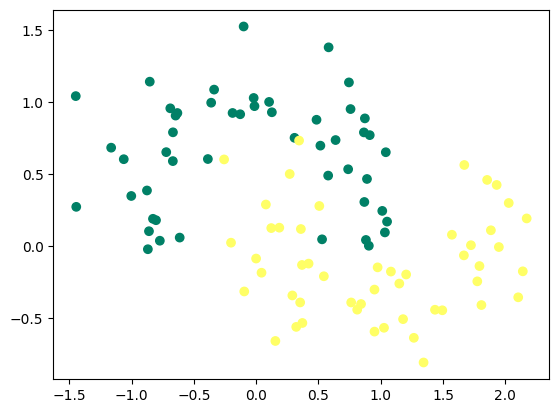

In [12]:
X, y = make_moons(n_samples=100, noise=0.2)
X = X.T
y = y.reshape((1, y.shape[0]))

print('dimensions de X :', X.shape)
print('dimensions de y :', y.shape)

plt.scatter(X[0, :], X[1, :], c=y, cmap='summer')
plt.show()

100%|██████████| 10000/10000 [00:12<00:00, 817.87it/s]


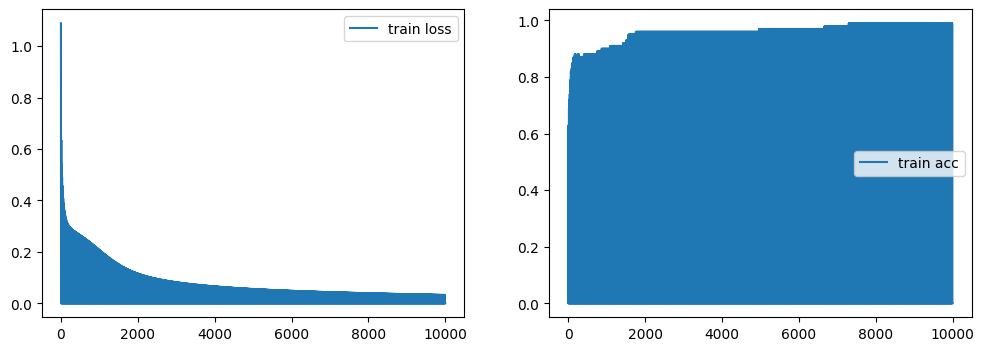

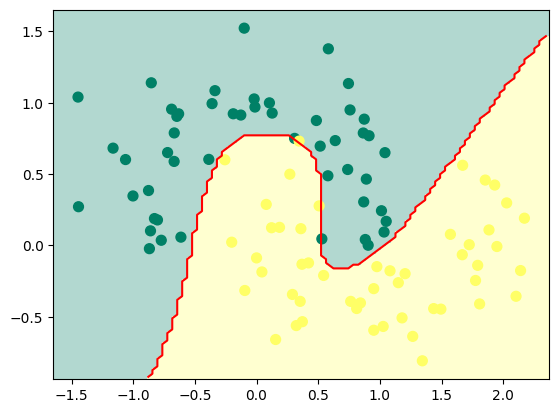

train accuracy : 0.99


In [13]:
training_history = deep_neural_network1(X, y, hidden_layers = (32, 32, 32), learning_rate = 0.1, n_iter = 10000)

100%|██████████| 10000/10000 [01:17<00:00, 129.65it/s]


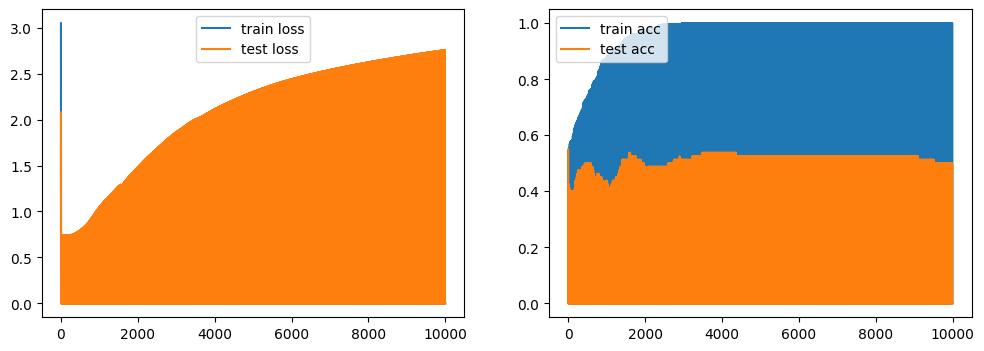

train accuracy : 1.0
test accuracy : 0.5


In [14]:
training_history, testing_history = deep_neural_network2(X_train_reshape, y_train, X_test_reshape, y_test, hidden_layers = (32, 32, 32, 32), learning_rate = 0.1, n_iter = 10000)